# Sutton & Barto Reinforcement Learning Book

In [1]:
from platform import python_version
python_version()

'3.6.6'

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Chapter 4: Dynamic Programming

## Example 4.1 Demonstration of iterative policy evaluation

<IMG SRC="images/gridworld.png">

### First set up the GridWorld environment

In [3]:
class GridWorld:
    
    name = 'GridWorld'
    roles = [1]
    possible_n_players = [1]
    help_text = {
        'Move format': "(row, col)",
        'Move not available': "That action is not available.",
        'Number of players': "This game is for 1 player."
    }
    actions = {
        'l': (0, -1),
        'u': (-1, 0),
        'r': (0, 1),
        'd': (1, 0)
    }

    def __init__(self, size=(4, 4), moves=None):

        self.size = size

        # Create all states
        self.terminal_states = [(0, 0), (3, 3)]
        self.states = [(row, col) for row in range(size[0])
                       for col in range(size[1])
                       if (row, col) not in self.terminal_states]

        # Start in random state
        self.start_state = random.choice(self.states)

        # Store rewards for all possible possible rewards
        self.rewards = {**{s: -1.0 for s in self.states}, 
                        **{s: 0.0 for s in self.terminal_states}}

        # Store next state and reward for all possible
        # state transitions
        self.turn = self.roles[0]
        self.transitions = {(s, a): (self.next_state(s, (self.turn, a)),
                                     self.rewards[s])
                            for s in self.states 
                            for a in self.actions}
        self.n_players = 1
        self.winner = None
        self.game_over = False
        self.reset()
        if moves is not None:
            for move in moves:
                self.make_move(move)

    def reset(self):
        
        self.moves = []
        self.state = self.start_state
        self.winner = None
        self.game_over = False

    def show_state(self):

        x = np.array(['_']*np.prod(game.size)).reshape(game.size)
        i_terminal_states = np.array(game.terminal_states).T
        x[i_terminal_states[0], i_terminal_states[1]] = 'X'
        x[game.state] = 'O'
        for row in x:
            print(" ".join(row))

    def available_moves(self, state=None):

        return list(self.actions.keys())

    def update_state(self, move):
        
        self.state = self.next_state(self.state, move)

    def next_state(self, state, move):

        role, action = move

        next_state = tuple(np.array(state) +
                           np.array(self.actions[action]))

        # Check if out of bounds
        if (next_state[0] < 0) or (next_state[0] >= self.size[0]) or \
            (next_state[1] < 0) or (next_state[1] >= self.size[1]):
            next_state = state

        if state in self.terminal_states:
            next_state = terminal_states[0]

        return next_state

    def make_move(self, move, show=False):
        
        assert self.game_over is False, "Game is over"

        self.update_state(move)
        self.moves.append(move)

        if show:
            role, action = move
            print("Player %s made move %s" % (str(role), str(action)))

        self.check_if_game_over()

    def get_rewards(self):
        """Returns reward resulting from the last action."""

        return {1: -1.0}

    def get_terminal_rewards(self):
        """Returns the reward after the terminal state."""

        assert self.game_over

        return {1: 0.0}   

    def check_if_game_over(self):

        if self.state in self.terminal_states:
            self.game_over, self.winner = True, self.turn

        return self.game_over

    def generate_state_key(self, state, role):

        return self.state

    def __repr__(self):

        return "GridWorld(%s)" % self.size.__repr__()

In [4]:
game = GridWorld()
game

GridWorld((4, 4))

In [5]:
game.roles, game.possible_n_players

([1], [1])

In [6]:
game.available_moves()

['l', 'u', 'r', 'd']

In [7]:
list(game.rewards.items())

[((0, 1), -1.0),
 ((0, 2), -1.0),
 ((0, 3), -1.0),
 ((1, 0), -1.0),
 ((1, 1), -1.0),
 ((1, 2), -1.0),
 ((1, 3), -1.0),
 ((2, 0), -1.0),
 ((2, 1), -1.0),
 ((2, 2), -1.0),
 ((2, 3), -1.0),
 ((3, 0), -1.0),
 ((3, 1), -1.0),
 ((3, 2), -1.0),
 ((0, 0), 0.0),
 ((3, 3), 0.0)]

In [8]:
list(game.transitions.items())[0:8]

[(((0, 1), 'l'), ((0, 0), -1.0)),
 (((0, 1), 'u'), ((0, 1), -1.0)),
 (((0, 1), 'r'), ((0, 2), -1.0)),
 (((0, 1), 'd'), ((1, 1), -1.0)),
 (((0, 2), 'l'), ((0, 1), -1.0)),
 (((0, 2), 'u'), ((0, 2), -1.0)),
 (((0, 2), 'r'), ((0, 3), -1.0)),
 (((0, 2), 'd'), ((1, 2), -1.0))]

In [9]:
game.show_state()

X _ _ _
_ _ _ O
_ _ _ _
_ _ _ X


In [10]:
game.make_move((1, 'r'))
game.show_state()

X _ _ _
_ _ _ O
_ _ _ _
_ _ _ X


In [11]:
game.get_rewards()

{1: -1.0}

In [12]:
while not game.game_over:
    game.make_move((1, random.choice(game.available_moves())))

In [13]:
game.get_terminal_rewards()

{1: 0.0}

### Create value functions

In [14]:
# State value-function
values = {s: 0.0 for s in game.states + game.terminal_states}
print("Length:", len(values))
values

Length: 16


{(0, 1): 0.0,
 (0, 2): 0.0,
 (0, 3): 0.0,
 (1, 0): 0.0,
 (1, 1): 0.0,
 (1, 2): 0.0,
 (1, 3): 0.0,
 (2, 0): 0.0,
 (2, 1): 0.0,
 (2, 2): 0.0,
 (2, 3): 0.0,
 (3, 0): 0.0,
 (3, 1): 0.0,
 (3, 2): 0.0,
 (0, 0): 0.0,
 (3, 3): 0.0}

In [15]:
def show_values(values, decimals=1):

    rows = max([k[0] for k, v in values.items()]) + 1
    cols = max([k[1] for k, v in values.items()]) + 1
    x = np.full((rows, cols), np.nan)
    for k, v in values.items():
        x[k] = round(v, decimals)
    print(x)

show_values(values)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [16]:
# Q (state, action) value function
q_values = {}
for s in game.states:
    for a in game.actions:
        q_values[(s, a)] = 0.0
print("Length:", len(q_values))
list(q_values.items())[0:8]

Length: 56


[(((0, 1), 'l'), 0.0),
 (((0, 1), 'u'), 0.0),
 (((0, 1), 'r'), 0.0),
 (((0, 1), 'd'), 0.0),
 (((0, 2), 'l'), 0.0),
 (((0, 2), 'u'), 0.0),
 (((0, 2), 'r'), 0.0),
 (((0, 2), 'd'), 0.0)]

In [17]:
def greedy_policy_with_state_values(game, state, action, values):
    """Returns the probability of taking the action in
    given state for a greedy policy with given state value
    function values."""

    actions = game.available_moves(state)

    # Requires the game's state-transition matrix
    action_values = {a: values[game.transitions[(state, a)][0]] 
                     for a in actions}
    v_max = max(action_values.items(), key=lambda x: x[1])

    return 1.0 if action == v_max[0] else 0.0

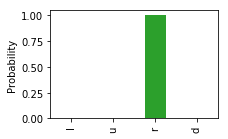

In [81]:
# Test above function
state = (1, 1)
actions = ['l', 'u', 'r', 'd']
test_values = {
 (1, 0): 1.0,
 (0, 1): 7.0,
 (1, 2): 9.0,
 (2, 1): 8.0
}
pd.Series([greedy_policy_with_state_values(game, state, a, test_values)
          for a in actions], index=actions).plot.bar(figsize=(3, 2))
plt.ylabel("Probability")
plt.show()

In [82]:
def greedy_policy_with_q_values(game, state, action, q_values):
    """Returns the probability of taking the action in
    given state for a greedy policy with given state-action
    value function q_values."""
    
    actions = game.available_moves(state)
    action_values = {a: q_values[(state, a)] for a in actions}
    v_max = max(action_values.items(), key=lambda x: x[1])

    return 1.0 if action == v_max[0] else 0.0

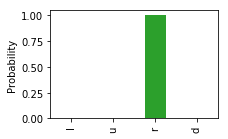

In [83]:
# Test above function
state = (1, 1)
actions = ['l', 'u', 'r', 'd']
test_q_values = {
 ((1, 1), 'l'): 1.0,
 ((1, 1), 'u'): 7.0,
 ((1, 1), 'r'): 9.0,
 ((1, 1), 'd'): 8.0
}
pd.Series([greedy_policy_with_q_values(game, state, a, test_q_values)
          for a in actions], index=actions).plot.bar(figsize=(3, 2))
plt.ylabel("Probability")
plt.show()

In [21]:
def random_policy(game, state, action, values=None):

    return 1.0/len(game.actions)

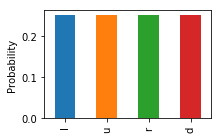

In [84]:
# Test above function
state = (1, 1)
actions = ['l', 'u', 'r', 'd']
pd.Series([random_policy(game, state, a)
          for a in actions], index=actions).plot.bar(figsize=(3, 2))
plt.ylabel("Probability")
plt.show()

In [22]:
def policy_action(game, policy, state, values):

    actions = game.available_moves(state)
    probs = [policy(game, state, a, values) for a in actions]

    return np.random.choice(actions, p=probs)

In [85]:
# Test above function
[policy_action(game, random_policy, (1, 1), values) for i in range(8)]

['r', 'r', 'u', 'u', 'r', 'u', 'r', 'l']

In [24]:
def bellman_equation(game, policy, values, lr):
    """Updates the value function using the Bellman
    equation (4.5)."""

    v = values.copy()

    for s in game.states:

        actions = game.available_moves(s)
        sum_values = 0.0

        for a in actions:

            p = policy(game, s, a, values)
            s2, r = game.transitions[(s, a)]
            if s2 in game.states:
                sum_values += p*(r + lr*values[s2])
            elif s2 in game.terminal_states:
                sum_values += p*r
        v[s] = sum_values

    return v

In [25]:
def evaluate_policy(policy, game, values, lr=1.0, theta=0.01, 
                    max_iter=1000, show=True, show_values=None):

    iteration = 0
    if show:
        print("\nk =", iteration)
        if show_values:
            show_values(values)

    while iteration < max_iter:

        updated_values = bellman_equation(game, policy, values, lr=lr)

        delta = np.abs(
            np.array(list(updated_values.values())) -
            np.array(list(values.values()))
        ).max()
        
        values = updated_values
        iteration += 1
        
        if show:
            print("\nk =", iteration)
            if show_values:
                show_values(values)

        if delta < theta:
            break
    
    if iteration == max_iter:
        print("\nMaximum iterations reached.")
    else:
        print("\nConverged to delta < %f after %d iterations" % 
              (theta, iteration))
    
    return values

### 1. Estimate optimal values using equi-probable random policy

In [26]:
values = {s: 0.0 for s in game.states + game.terminal_states}

In [27]:
values = evaluate_policy(random_policy, game, values, max_iter=10, 
                         show=True, show_values=show_values)


k = 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

k = 1
[[ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1.  0.]]

k = 2
[[ 0.  -1.8 -2.  -2. ]
 [-1.8 -2.  -2.  -2. ]
 [-2.  -2.  -2.  -1.8]
 [-2.  -2.  -1.8  0. ]]

k = 3
[[ 0.  -2.4 -2.9 -3. ]
 [-2.4 -2.9 -3.  -2.9]
 [-2.9 -3.  -2.9 -2.4]
 [-3.  -2.9 -2.4  0. ]]

k = 4
[[ 0.  -3.1 -3.8 -4. ]
 [-3.1 -3.7 -3.9 -3.8]
 [-3.8 -3.9 -3.7 -3.1]
 [-4.  -3.8 -3.1  0. ]]

k = 5
[[ 0.  -3.7 -4.7 -4.9]
 [-3.7 -4.5 -4.8 -4.7]
 [-4.7 -4.8 -4.5 -3.7]
 [-4.9 -4.7 -3.7  0. ]]

k = 6
[[ 0.  -4.2 -5.5 -5.8]
 [-4.2 -5.2 -5.6 -5.5]
 [-5.5 -5.6 -5.2 -4.2]
 [-5.8 -5.5 -4.2  0. ]]

k = 7
[[ 0.  -4.7 -6.3 -6.7]
 [-4.7 -5.9 -6.4 -6.3]
 [-6.3 -6.4 -5.9 -4.7]
 [-6.7 -6.3 -4.7  0. ]]

k = 8
[[ 0.  -5.2 -7.  -7.5]
 [-5.2 -6.5 -7.1 -7. ]
 [-7.  -7.1 -6.5 -5.2]
 [-7.5 -7.  -5.2  0. ]]

k = 9
[[ 0.  -5.7 -7.7 -8.2]
 [-5.7 -7.2 -7.8 -7.7]
 [-7.7 -7.8 -7.2 -5.7]
 [-8.2 -7.7 -5.7  0. ]]

k = 10
[[ 0.  -6.1 -8.4 -9. ]
 [-6.1 -7.7 -8.4 

### 2. Greedy policy

In [28]:
values

{(0, 1): -6.137969970703125,
 (0, 2): -8.35235595703125,
 (0, 3): -8.967315673828125,
 (1, 0): -6.137969970703125,
 (1, 1): -7.737396240234375,
 (1, 2): -8.427825927734375,
 (1, 3): -8.35235595703125,
 (2, 0): -8.35235595703125,
 (2, 1): -8.427825927734375,
 (2, 2): -7.737396240234375,
 (2, 3): -6.137969970703125,
 (3, 0): -8.967315673828125,
 (3, 1): -8.35235595703125,
 (3, 2): -6.137969970703125,
 (0, 0): 0.0,
 (3, 3): 0.0}

In [29]:
def show_actions(game, policy, values):

    x = np.array(['_']*np.prod(game.size), dtype='<U1').reshape(game.size)
    for s in game.states:
        x[s] = policy_action(game, policy, s, values)
    
    print(x.__repr__())

# Optimal actions
show_actions(game, greedy_policy_with_state_values, values)

array([['_', 'l', 'l', 'l'],
       ['u', 'l', 'l', 'd'],
       ['u', 'u', 'r', 'd'],
       ['u', 'r', 'r', '_']], dtype='<U1')


In [30]:
game.states

[(0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2)]

In [31]:
# Define true optimal actions so we can confirm
# if a policy is optimal
array_of_actions = np.array([
    ['', 'l', 'l', 'ld'],
    ['u', 'lu', 'lurd', 'd'],
    ['u', 'lurd', 'rd', 'd'],
    ['ur', 'r', 'r', '']
], dtype='<U4')
optimal_actions = {index: x for index, x in 
                   np.ndenumerate(array_of_actions)
                   if index not in game.terminal_states}
optimal_actions

{(0, 1): 'l',
 (0, 2): 'l',
 (0, 3): 'ld',
 (1, 0): 'u',
 (1, 1): 'lu',
 (1, 2): 'lurd',
 (1, 3): 'd',
 (2, 0): 'u',
 (2, 1): 'lurd',
 (2, 2): 'rd',
 (2, 3): 'd',
 (3, 0): 'ur',
 (3, 1): 'r',
 (3, 2): 'r'}

In [32]:
def test_policy(game, policy, values, optimal_actions):
    """Returns an accuracy score for policy according to
    how many optimal actions it makes in each state based
    on optimal_actions.
    """

    a_array = np.zeros(game.size, dtype=bool)
    for s, opt in optimal_actions.items():
        a = policy_action(game, policy, s, values)
        if a in opt:
            a_array[s] = True
        else:
            a_array[s] = False
    
    return a_array.sum()/len(game.states)

In [33]:
test_policy(game, greedy_policy_with_state_values, values, optimal_actions)

1.0

### 3. Calculate Q-values

In [34]:
def q_values_from_values(game, values, lr=1.0):

    q_values = {}
    for s in game.states:

        sum_values = 0
        actions = game.available_moves(s)
        for a in actions:
            next_state, reward = game.transitions[(s, a)]

            # Q-value is value of next state + reward (?)
            v_next = values[next_state] + reward
            q_values[(s, a)] = v_next

    return q_values

In [35]:
game.transitions[((1, 0), 'l')]

((1, 0), -1.0)

In [36]:
q_values = q_values_from_values(game, values)
q_values

{((0, 1), 'l'): -1.0,
 ((0, 1), 'u'): -7.137969970703125,
 ((0, 1), 'r'): -9.35235595703125,
 ((0, 1), 'd'): -8.737396240234375,
 ((0, 2), 'l'): -7.137969970703125,
 ((0, 2), 'u'): -9.35235595703125,
 ((0, 2), 'r'): -9.967315673828125,
 ((0, 2), 'd'): -9.427825927734375,
 ((0, 3), 'l'): -9.35235595703125,
 ((0, 3), 'u'): -9.967315673828125,
 ((0, 3), 'r'): -9.967315673828125,
 ((0, 3), 'd'): -9.35235595703125,
 ((1, 0), 'l'): -7.137969970703125,
 ((1, 0), 'u'): -1.0,
 ((1, 0), 'r'): -8.737396240234375,
 ((1, 0), 'd'): -9.35235595703125,
 ((1, 1), 'l'): -7.137969970703125,
 ((1, 1), 'u'): -7.137969970703125,
 ((1, 1), 'r'): -9.427825927734375,
 ((1, 1), 'd'): -9.427825927734375,
 ((1, 2), 'l'): -8.737396240234375,
 ((1, 2), 'u'): -9.35235595703125,
 ((1, 2), 'r'): -9.35235595703125,
 ((1, 2), 'd'): -8.737396240234375,
 ((1, 3), 'l'): -9.427825927734375,
 ((1, 3), 'u'): -9.967315673828125,
 ((1, 3), 'r'): -9.35235595703125,
 ((1, 3), 'd'): -7.137969970703125,
 ((2, 0), 'l'): -9.352355957

In [37]:
greedy_policy_with_q_values(game, (1, 0), 'r', q_values)

0.0

In [38]:
greedy_policy_with_q_values(game, (1, 0), 'u', q_values)

1.0

In [39]:
test_policy(game, greedy_policy_with_q_values, q_values, optimal_actions)

1.0

### Exercise 4.1

In Example 4.1, if $\pi$ is the equiprobable random policy,

- What is $q_\pi(11,down)$?
- What is $q_\pi(7,down)$?

$q_\pi(11,down)$:

In [40]:
q_values[((2, 3), 'd')]

-1.0

$q_\pi(7,down)$:

In [41]:
q_values[((1, 3), 'd')]

-7.137969970703125

## Example 4.2 Jack’s Car Rental

Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited \$10 by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of \$2 per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is
$n$ is $\frac{\lambda^n}{n!}\mathrm{e}^{-\lambda}$, where $\lambda$ is the expected number.

Suppose $\lambda$ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be $\gamma = 0.9$ and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.

In [42]:
from scipy.special import factorial
lam1, lam2 = 3, 4

def prob_request(n, lam):
    
    return lam**n/factorial(n)*np.exp(-lam)

n_max = 20
n = np.arange(0, n_max + 1)
probs = prob_request(n, lam1), prob_request(n, lam2)


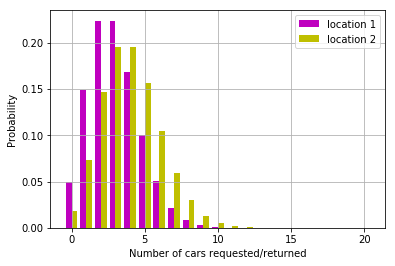

In [43]:
# Plot pdf
ax = plt.subplot(111)
ax.bar(n-0.2, probs[0], width=0.4, color='m', align='center', label="location 1")
ax.bar(n+0.2, probs[1], width=0.4, color='y', align='center', label="location 2")

plt.xlabel("Number of cars requested/returned")
plt.ylabel("Probability")
plt.legend()
plt.grid()

In [44]:
states = []
for c1 in range(n_max + 1):
    for c2 in range(n_max + 1):
        states.append((c1, c2))
print(states[0:3])
len(states)

[(0, 0), (0, 1), (0, 2)]


441

In [45]:
# State value-function
values = {s: 0 for s in states}
list(values.items())[0:3]

[((0, 0), 0), ((0, 1), 0), ((0, 2), 0)]

In [46]:
def available_actions(state):
    """Determine how many cars are available for moving.
    Return as a list of number of cars movable.
    """
    
    s1, s2 = state
    
    actions = list(range(-min(s2, n_max - s1), 
                         min(s1, n_max - s2) + 1))
    
    return actions

def next_state(state, policy, values):
    
    s1, s2 = state
    
    actions = available_actions(state)
    cars_moved = policy_action(policy, state, actions, values)

    cars_rented = [np.random.choice(n, p=p) for p in probs]
    cars_returned = [np.random.choice(n, p=p) for p in probs]

    for i in range(2):
        
        # Rent cars if available
        cars_rented[i] = min(state[i], cars_rented[i])
        
        # Return cars if space available
        cars_returned[i] = min(n_max - state[i], cars_returned[i])
    
    s1 = s1 + cars_rented[0] - cars_returned[0] - cars_moved
    s2 = s2 + cars_rented[1] - cars_returned[1] + cars_moved

    cost = 2*cars_moved - 10*sum(cars_rented)
    
    return (s1, s2), cost

In [47]:
# Test
next_state((10, 10), random_policy, values)

AttributeError: 'function' object has no attribute 'available_moves'

In [ ]:
values

In [ ]:
states[0]

In [ ]:
def show_values(values, r=1):
    """Displays the values rounded to r decimal places.
    """
    
    v_array  = np.zeros((n_max+1, n_max+1))
    for s, v in values.items():
        v_array[s] = v
    print(v_array.round(r))

show_values(values)

In [ ]:
# TODO: This is not working...
#evaluate_policy(random_policy, states, actions, transitions=None,  
#                values=values, lr=1.0, theta=0.01, max_iter=10,
#                show=True, show_values=show_values)

## Chapter 6: TD Learning

### Example 6.2 Random walk

In [ ]:
from gamelearner import GameController, RandomPlayer, TDLearner

In [ ]:
import string

In [ ]:
class RandomWalkGame():
    
    name = 'Random Walk'
    terminal_states = ['T1', 'T2']
    roles = [1]
    possible_n_players = [1]
    help_text = {
        'Move format': "l/r",
        'Move not available': "That action is not available.",
        'Number of players': "This game is for 1 player."
    }

    def __init__(self, size=5, moves=None):
        
        self.size = size
        assert 1 < size <= 26
        
        # Create states
        self.states = [self.terminal_states[0]] + \
                       list(string.ascii_uppercase[:size]) + \
                       [self.terminal_states[1]]
        
        # Start in middle position
        self.start_state = self.states[self.size//2 + 1]
        self.rewards = {'T1': 0.0, 'T2': 1.0}
        self.dynamics = {}
        for i in range(1, self.size + 1):
            s_left = self.states[i - 1]
            s_right = self.states[i + 1]
            self.dynamics[self.states[i]] = {'l': s_left, 'r': s_right}
        self.n_players = 1
        self.turn = 1
        self.winner = None
        self.game_over = False
        self.reset()
        if moves is not None:
            for move in moves:
                self.make_move(move)

    def reset(self):
        
        self.moves = []
        self.state = self.start_state
        self.winner = None
        self.game_over = False

    def show_state(self):

        print(self.state)

    def available_moves(self, state=None):

        if state is None:
            state = self.state

        return list(self.dynamics[state].keys())

    def update_state(self, move):
        
        self.state = self.next_state(self.state, move)

    def next_state(self, state, move):

        role, action = move

        return self.dynamics[state][action]

    def make_move(self, move, show=False):
        
        assert self.game_over is False, "Game is over"

        self.update_state(move)
        self.moves.append(move)

        if show:
            role, action = move
            print("Player %s made move %s" % (str(role), str(action)))

        self.check_if_game_over()

    def get_rewards(self):
        """Returns any rewards at the current time step.  In
        RandomWalk, there are no rewards until the end of the
        game so send a zero reward."""

        return {1: 0.0}

    def get_terminal_rewards(self):
        """Returns the reward after the terminal state was
        reached."""

        assert self.game_over

        return {1: self.rewards.get(game.state, 0.0)}   

    def check_if_game_over(self):

        if self.state in self.terminal_states:
            self.game_over, self.winner = True, 1

        return self.game_over

    def generate_state_key(self, state, role):

        return self.state

    def __repr__(self):

        return "RandomWalkGame(%d)" % self.size


In [ ]:
game = RandomWalkGame()
game.possible_n_players

In [ ]:
game.states

In [ ]:
game.show_state()

In [ ]:
game.make_move((1, 'r'), show=True)

In [ ]:
game.show_state()

In [ ]:
game.get_rewards()

In [ ]:
game.make_move((1, 'r'))
game.show_state()

In [ ]:
game.get_rewards()

In [ ]:
game.make_move((1, 'l'))
game.show_state()

In [ ]:
game.make_move((1, 'r'))
game.show_state()

In [ ]:
game.make_move((1, 'r'))
game.show_state()

In [ ]:
game.game_over

In [ ]:
game.get_rewards()

In [ ]:
game.get_terminal_rewards()

In [ ]:
game = RandomWalkGame()
player = RandomPlayer()
ctrl = GameController(game, [player])
ctrl.play(show=False)
ctrl.announce_result()

In [ ]:
game.reset()
player = TDLearner(initial_value=0.5)
ctrl = GameController(game, [player])
ctrl.play(show=True)

### TD(0) Updates on Random Walk

Equation (6.2)

$V(S_t) \leftarrow V(S_t) + \alpha [R_{t+1} + \gamma V(S_{t+1}) - V(S_t)]$

In [ ]:
size = 5
game = RandomWalkGame(size=size)
gamma = 1.0
learning_rate = 0.1

initial_value = 0.5
value_function = {s: initial_value for s in game.states}
value_function['T1'] = 0.0
value_function['T2'] = 0.0

episodes_to_record = [0, 1, 10, 100]
value_sets = {}

np.random.seed(5)

n_iters = 1001
for iteration in range(n_iters):
    
    if iteration in episodes_to_record:
        value_sets[iteration] = value_function.copy()

    past_states = [game.state]

    while True:

        # Behaviour policy
        move = np.random.choice(game.available_moves())
        game.make_move([1, move])
        past_states.append(game.state)

        reward = game.get_rewards()[1]

        # TD(0) update
        if not game.game_over:
            value_function[past_states[-2]] += \
                    learning_rate*(
                            reward + gamma*value_function[past_states[-1]] -
                            value_function[past_states[-2]]
                    )
        else:
            reward = game.get_terminal_rewards()[1]
            value_function[past_states[-2]] += \
                learning_rate*(reward - value_function[past_states[-2]])
            break

    game.reset()

In [ ]:
states = game.states[1:size+1]
true_values = pd.Series([x*(1/(size+1)) for x in range(size+2)][1:size+1], 
                       index=states)

fig, ax = plt.subplots()

for i, value_function in value_sets.items():
    values = list(value_function.values())[1:size+1]
    ax.plot(states, values, marker='o', label=str(i))
ax.plot(true_values.index, true_values, linestyle='--', label='True values')
plt.title('TD(0) Value Updates on Random Walk')
ax.set_xlabel('State')
ax.set_ylabel('Value')
plt.legend()
plt.savefig("random_walk_td0.pdf")
plt.grid()

## Chapter 7: n-step Bootstrapping

## n-step TD

<IMG SRC="tdlambda.png">

### Example 7.1 Random walk

n-step TD Updates on Random Walk

In [ ]:
size = 19
game = RandomWalkGame(size=size)

# Change rewards for this exercise
game.rewards = {'T1': -1.0, 'T2': 1.0}

# Initialization of parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0
n = 5

# Initialise value function
value_function = {
    s: 0.0 if s in game.terminal_states else initial_value
    for s in game.states
}

episodes_to_record = [0, 1, 10, 100]
value_sets = {}

np.random.seed(5)

n_iters = 101
for iteration in range(n_iters):
    
    if iteration in episodes_to_record:
        value_sets[iteration] = value_function.copy()

    past_states = [game.state]
    past_rewards = [None]
    
    T = 999999
    t = 0
    while True:

        # Behaviour policy
        if t < T:
            move = np.random.choice(game.available_moves())
            game.make_move([1, move])
            past_states.append(game.state)
            if not game.game_over:
                reward = game.get_rewards()[1]
            else:
                reward = game.get_terminal_rewards()[1]
            past_rewards.append(reward)
            if game.game_over:
                T = t + 1

        #import pdb; pdb.set_trace()

        # State to be updated
        tau = t - n + 1
        
        # TD(λ) update
        if tau >= 0:
            g = 0
            for i in range(tau + 1, min(tau + n, T) + 1):
                g += gamma**(i - tau - 1)*past_rewards[i]
            if tau + n < T:
                g += gamma**n*value_function[past_states[tau + n]]

            value_function[past_states[tau]] += \
                learning_rate*(g - value_function[past_states[tau]])
        
        t += 1
        if tau == T - 1:
            break

    game.reset()

In [ ]:
states = game.states[1:size+1]
true_values = pd.Series([(2*x*(1/(size+1)) - 1)
                         for x in range(size+2)][1:size+1], 
                        index=states)

fig, ax = plt.subplots()

for i, value_function in value_sets.items():
    values = list(value_function.values())[1:size+1]
    ax.plot(states, values, marker='o', label=str(i))
ax.plot(true_values.index, true_values, linestyle='--', 
        label='True values')
plt.title('TD(%d) Value Updates on Random Walk' % n)
ax.set_xlabel('State')
ax.set_ylabel('Value')
plt.legend()
plt.savefig("random_walk_td%d_19.pdf" % n)
plt.grid()

In [ ]:
pd.DataFrame(value_sets)

### RMS error metric

In [ ]:
true_values

In [ ]:
def rms_error(x, true_values):
    """Root-mean-squared error in values
    """
    
    return np.sqrt(np.sum((x - true_values)**2)/len(x))

true_values = np.array(
    [(game.rewards['T1']*(1 - x) + game.rewards['T2']*x)
     for x in np.linspace(0.0, 1.0, size + 2)]
)[1:size+1]

values = np.array(list(value_sets[100].values()))[1:size+1]
rms_error(values, true_values)

### n-step TD - effect of variation in n (and alpha)

In [ ]:
size = 19
game = RandomWalkGame(size=size)
game.rewards = {'T1': -1.0, 'T2': 1.0}

true_values = np.array(
    [(game.rewards['T1']*(1 - x) + game.rewards['T2']*x) for x in np.linspace(0.0, 1.0, size + 2)]
)[1:size+1]

# Initialization of parameters
initial_value = 0.0
gamma = 1.0

# Iterate over learning_rates and n_values
learning_rates = np.linspace(0.01, 1.0, 100)
n_values = [2**i for i in range(8)]

rms_error_sets = {}

# TODO: Should be repeating the test 100 times for each
# pair of n, alpha values and averaging the results.
for n in n_values:

    rms_results = []

    for learning_rate in learning_rates:

        # Initialise value function
        value_function = {
            s: 0.0 if s in game.terminal_states else initial_value
            for s in game.states
        }

        np.random.seed(5)

        n_iters = 10
        for iteration in range(n_iters):

            past_states = [game.state]
            past_rewards = [None]

            T = 999999
            t = 0
            while True:

                # Behaviour policy
                if t < T:
                    move = np.random.choice(game.available_moves())
                    game.make_move([1, move])
                    past_states.append(game.state)
                    if not game.game_over:
                        reward = game.get_rewards()[1]
                    else:
                        reward = game.get_terminal_rewards()[1]
                    past_rewards.append(reward)
                    if game.game_over:
                        T = t + 1

                #import pdb; pdb.set_trace()

                # State to be updated
                tau = t - n + 1

                # TD(λ) update
                if tau >= 0:
                    g = 0
                    for i in range(tau + 1, min(tau + n, T) + 1):
                        g += gamma**(i - tau - 1)*past_rewards[i]
                    if tau + n < T:
                        g += gamma**n*value_function[past_states[tau + n]]

                    value_function[past_states[tau]] += \
                                learning_rate*(g - value_function[past_states[tau]])

                t += 1
                if tau == T - 1:
                    break

            game.reset()

        values = np.array(list(value_function.values())[1:size+1])
        rms_results.append(rms_error(values, true_values))

    rms_error_sets[n] = rms_results

In [ ]:
# Plot results
states = game.states[1:size+1]

fig, ax = plt.subplots()

for n, rms_errors in rms_error_sets.items():
    ax.plot(learning_rates, rms_errors, label='n = %d' % n)
plt.title('n-step TD value error on random walk (%d states)' % game.size)
ax.set_xlabel('Learning rate (alpha)')
ax.set_ylabel('RMS Error')
ax.set_ylim(0.0, 0.55)
plt.legend()
plt.grid()
plt.savefig("random_walk_tdl_%d.pdf" % game.size)
plt.show()

## 8.7 Real-Time Dynamic Programming

### Exercise 8.8

In [ ]:
import numpy as np

class RandomStatesExperiment():

    name = 'Random States Experiment'
    roles = [1]
    possible_n_players = [1]
    help_text = {
        'Move format': "0 or 1",
        'Move not available': "That action is not available.",
        'Number of players': "This game is for 1 player."
    }

    def __init__(self, b, size=1000, moves=None, 
                 terminal_reward=0.0, seed=1):
        """Experiment described in section 8.6 of Sutton
        and Barto book to test Trajectory Sampling
        methods.

        Args:
            b (int): Branching factor.
            size (int): Number of states.
            moves (list): Optional. Provide a list of completed
                moves. Each move should be a tuple of length 2
                where the first item is the player role (1) and
                the second is the action (0 or 1).
            terminal_reward (float): Final reward when terminal
                state is reached.
            seed (int): Change this to produce a different
                random environment.
        """

        self.b = b
        self.size = size
        self.seed = seed

        self.states = np.arange(0, size + 1)

        # Last state is terminal state
        self.terminal_states = [self.states[-1]]

        # Initialize a random number generator for
        # generating random state transitions and
        # rewards
        self.rng = np.random.RandomState(seed)

        # First, create random state transitions
        self.branches = {}
        for state in self.states:
            self.branches[state] = {
                0: self.rng.choice(self.states, size=b), 
                1: self.rng.choice(self.states, size=b)
            }
        self.start_state = self.rng.choice(self.states)
        
        self.terminal_reward = terminal_reward
        
        self.n_players = 1
        self.turn = 1
        self.winner = None
        self.game_over = False
        self.states = None
        self.moves = None
        self.reset()
        if moves is not None:
            for move in moves:
                self.make_move(move)

    def reset(self):

        self.states = []
        self.moves = []
        self.state = self.start_state
        self.winner = None
        self.game_over = False

    def show_state(self):

        print(self.state)

    def available_moves(self):

        return (0, 1)

    def next_state(self, state, move):

        if np.random.random() < 0.1:
            next_state = self.terminal_states[0]
        else:
            role, action = move
            next_state = np.random.choice(
                self.branches[state][action]
            )

        return next_state

    def update_state(self, move):

        self.state = self.next_state(self.state, move)

    def make_move(self, move, show=False):
        
        assert self.game_over is False, "Game is over"

        self.states.append(self.state)
        self.update_state(move)
        self.moves.append(move)

        if show:
            role, action = move
            print("Player %s made move %s" % (str(role), str(action)))

        self.check_if_game_over()

    def get_rewards(self):
        """Returns the reward at the current time step.  In
        this experiment, the reward of each transition is
        different and selected from a Gaussian distribution.
        Rather than store all the fixed rewards in memory,
        we regenerate them deterministically when needed using
        a seeded random number generator.
        """

        # Use previous state + seed to set RNG state
        # so that rewards are deterministic for any
        # state transition
        self.rng.seed(self.states[-1] + self.seed)
        last_action = self.moves[-1][1]

        # Return the reward for the last action taken
        reward = self.rng.normal(size=self.b)[last_action]

        return {1: reward}

    def get_terminal_rewards(self):
        """Returns the reward after the terminal state was
        reached."""

        assert self.game_over

        return {1: 0.0}   

    def check_if_game_over(self):

        if self.state in self.terminal_states:
            self.game_over, self.winner = True, 1

        return self.game_over

    def generate_state_key(self, state, role):

        return self.state

    def __repr__(self):

        return "RandomWalkGame(%d)" % self.size

In [ ]:
game = RandomStatesExperiment(b=5, size=1000)

In [ ]:
game.show_state()

In [ ]:
game.start_state, game.terminal_states

In [ ]:
game.available_moves()

In [ ]:
# Find all possible next states with action 0
next_states = set()
for i in range(100):
    next_states.add(game.next_state(game.state, (1, 0)))
next_states

In [ ]:
# Find all possible next states with action 1
next_states = set()
for i in range(100):
    next_states.add(game.next_state(game.state, (1, 1)))
next_states

In [ ]:
game.roles, game.turn

In [ ]:
game.make_move([1, 0], show=True)
game.show_state()

In [ ]:
game.moves

In [ ]:
from gamelearner import RandomPlayer, TDLearner, GameController
td_player = TDLearner()
td_player.learning_rate, td_player.off_policy_rate

In [ ]:
game.reset()
ctrl = GameController(game, [td_player])
ctrl.play(show=True)

In [ ]:
list(td_player.value_function.items())[0:10]

In [ ]:
td_player.value_function[game.start_state]